In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

## Imports

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers

In [4]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')
matplotlib.rcParams.update({'font.size': 10})

## formatting

In [6]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

plt.style.use('default')
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})

## Paths and directories

In [7]:
ROOT_DIR = pathlib.Path("/content/drive/MyDrive/Research/PAPER_1_CODE")
PV_DIR = ROOT_DIR/"PVS"
MODELS_DIR = ROOT_DIR/"models"

Import custom modules

In [8]:
import importlib.util
import sys
from pathlib import Path

# Set the full path to the parent directory of the package
parent_path = '/content/drive/MyDrive/Research/PAPER_1_CODE/pkg'

# Add the parent directory to the system path
sys.path.append(parent_path)

# Import the package (and execute __init__.py)
from pv_analysis.cardiovascular_data import CardiovascularData
from pv_analysis.pv_analyst import PV_Analyst
from pv_generator.pv_generator import gen_valid_pv

# Load PV Generator

In [9]:
CVSIMF_DIR = PV_DIR/"CVSIM_FILTERED"
pv_files = [str(CVSIMF_DIR/v) for v in os.listdir(str(CVSIMF_DIR)) if v.endswith(".csv")]
pv_samples = []
for filename in pv_files:
  pv_samples.append(pd.read_csv(filename))

In [10]:
gen_args = {
 'allow_initial_values_to_exceed_bounds': True,
 'chance_of_mutation': None,
 'chance_of_noise': None,
 'chance_of_pressure_mutation': None,
 'chance_of_roll': None,
 'chance_of_volume_mutation': None,
 'max_signal_noise': 0.0025,
 'random_horizontal_translation': [-0.6, 0.6],
 'random_pressure_scale': [1.2, 2.0],
 'random_vertical_translation': [-0.3, 0.3],
 'random_volume_scale': [1.0, 4.0],
 'resize_to': 50,
 'set_initial_pres_to': 0.1,
 'set_initial_vol_to': 1.0,
 'set_max_initial_pressure_to': None,
 'set_pressure_bounds_to': [0.001, None],
 'set_pressure_deltas_to': None,
 'set_volume_bounds_to': [0.05, 1.0],
 'set_volume_deltas_to': None,

 'min_ef':0.35, 
 'max_ef':0.65, 
 'min_max_ps':0.6,
 'max_max_ps':1.25
 }

In [11]:
def plot_pv(pvtrue, figsize=(12,3)):

  fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 2]})

  xs = np.linspace(0, 1, len(pvtrue))

  axs[0].plot(pvtrue[:, 1], pvtrue[:, 0], "-.", c="red")
  axs[0].scatter(pvtrue[:, 1], pvtrue[:, 0], c="red")
  
  axs[1].plot(xs, pvtrue[:, 0], "-.", c="red")
  axs[1].twinx().plot(xs, pvtrue[:, 1], "-.", c="orange")

  axs[0].axis('equal')
  # axs[1].axis('equal')

  return fig, axs

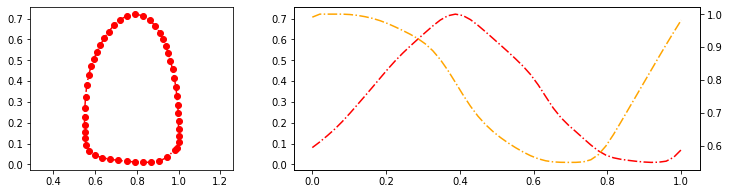

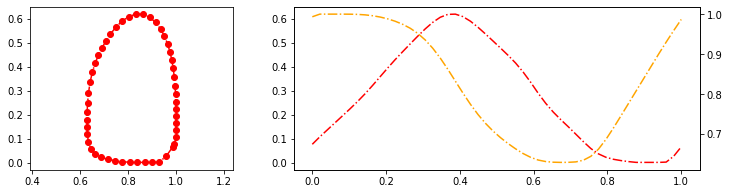

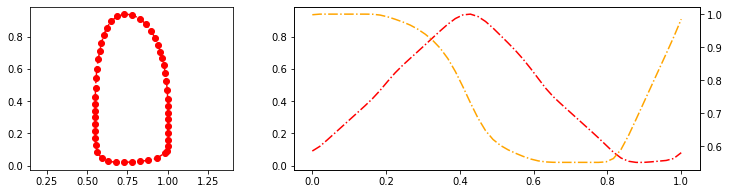

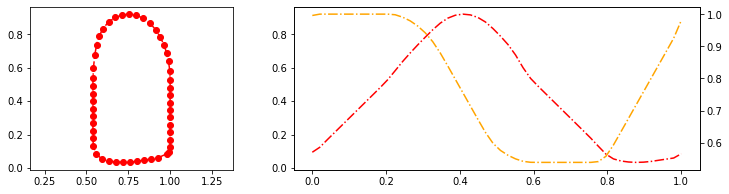

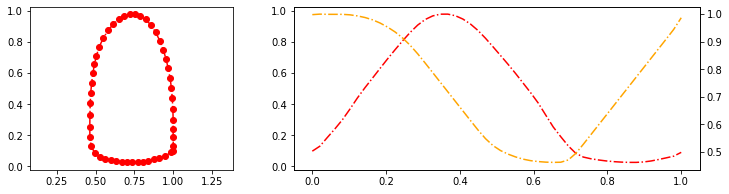

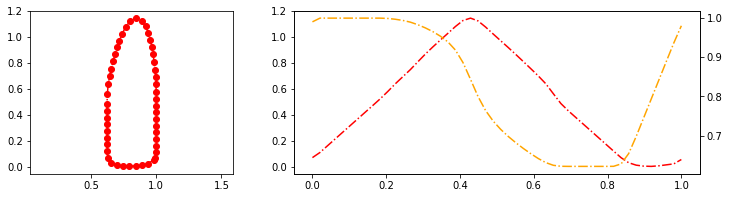

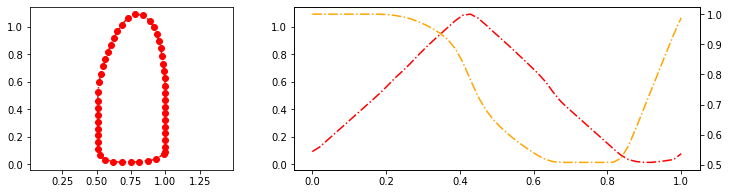

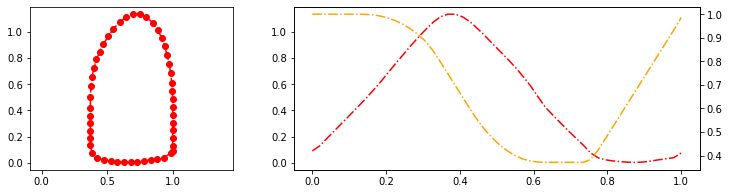

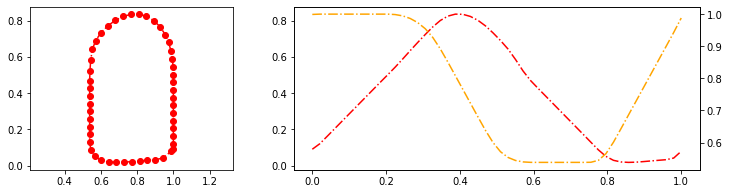

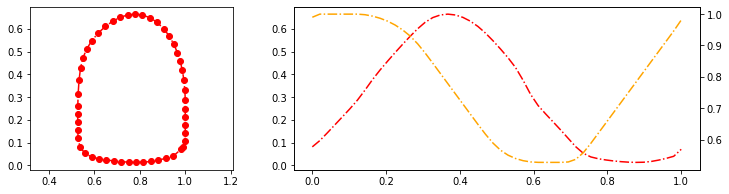

In [12]:
for _ in range(10):
  pv = gen_valid_pv(pv_samples, **gen_args)
  plot_pv(pv)

# Set Gen DS tf.functions

In [13]:
CM_LABELS = ["LS", "RS", "WT", "SL", "SC", "EF"]

## Load models

In [14]:
def load_untrainable_model(pathlike):
  model = tf.keras.models.load_model(str(pathlike), compile=False)
  model.trainable = False
  return model

In [15]:
LVGAMMA4 = load_untrainable_model(MODELS_DIR/"PAT_GAMMA_REGRESSOR"/"best") # used to oredict gamma

In [16]:
LVGEOMETRICS4 = load_untrainable_model(MODELS_DIR/"PAT_GM_REGRESSOR"/"best") # used to predict geochars

In [17]:
PV_ENCODER = load_untrainable_model(MODELS_DIR/"PV_ENCODER"/"best")

## PV functions

In [18]:
@tf.function()
def gen_pv_tfwrap():
  """ wraps gen_valid_pv into tf function """
  def gen():
    return gen_valid_pv(pv_samples, **gen_args)
  return tf.numpy_function(gen, [], [tf.float32])

In [19]:
@tf.function()
def rand_pv(pv):
  """ randomized pv """

  def apply_rand(pv):
    ps = pv[:, 0]
    vs = pv[:, 1]

    rand_y_translate = np.random.uniform(-0.099, 0.06) # [0.01, 0.20] -> starts at 0.1
    ps += rand_y_translate

    ps = ps.reshape((-1,1))
    vs = vs.reshape((-1,1))

    return np.hstack((ps, vs))
  
  return tf.numpy_function(apply_rand, [pv], tf.float32)

In [20]:
@tf.function()
def adjust_pressure(pv):
  """ Makes sure pv is not negative """
  def fun(pv):
    ps = pv[:, 0]
    min_p = np.min(ps)
    if min_p < 0:
      pv[:, 0] -= min_p
    return pv
  return tf.numpy_function(fun, [pv], tf.float32)

In [21]:
@tf.function()
def match_initial_and_final_states(pv):
  """ set last data equal to inital value """

  def apply_mod(pv):
    pv = np.vstack((pv, pv[0]))
    return pv
  
  return tf.numpy_function(apply_mod, [pv], tf.float32)

In [22]:
@tf.function()
def rand_pv_and_match_boundary_states(pv):
  pv = rand_pv(pv)
  pv = adjust_pressure(pv)
  pv = match_initial_and_final_states(pv)
  return pv

In [23]:
@tf.function()
def gen_pv_rand_and_match_initial_and_final_states():
  pv = gen_pv_tfwrap()[0]
  pv = rand_pv(pv)
  pv = adjust_pressure(pv)
  pv = match_initial_and_final_states(pv)
  return pv

In [24]:
@tf.function()
def scale_pv_for_display(pv):
  """ set last data equal to inital value """

  def apply_mod(pv):
    pv[:, 0] *= 16.0
    pv[:, 1] *= 121.1895 # ideal
    return pv
  
  return tf.numpy_function(apply_mod, [pv], tf.float32)

## Compute Geometrics and Clinical metrics

In [25]:
@tf.function()
def get_pv_phases_idxs(pv):
  def fun(pv):
    pva = PV_Analyst(pv)
    return pva.get_pv_phases()[1].astype(np.int32)
  return tf.numpy_function(fun, [pv], tf.int32)

In [26]:
@tf.function()
def get_ed_and_es_from_pv(pv):
  """ Returns p,v values for end-diastole and end-systole """
  def fun(pv):
    pva = PV_Analyst(pv)
    phases_idxs = pva.get_pv_phases()[1].astype(np.int32)
    ed, es = phases_idxs[0], phases_idxs[2] # end-diastole, end_systole
    ed_val = pv[ed]# [p,v] at end-diastole
    es_val = pv[es]# [p,v] at end_systole
    return np.vstack((ed_val, es_val)).astype(np.float32)
  return tf.numpy_function(fun, [pv], tf.float32)

In [27]:
@tf.function()
def compute_geometrics(pv, fo):
  """ returns geometrics for end-systole and end-diastole """
  def fun(pv, fo):
    # get pv values at end-diastole and end-systole
    ed_val, es_val = get_ed_and_es_from_pv(pv)
    # expand dims of pv value to match fo
    ed_val = tf.tile([ed_val], [fo.shape[0],1])
    es_val = tf.tile([es_val], [fo.shape[0],1])
    # concat pv and fo
    gc_ed_in = tf.concat((fo, ed_val), 1)
    gc_es_in = tf.concat((fo, es_val), 1)
    # get geometrics
    gc_ed = LVGEOMETRICS4(gc_ed_in)
    gc_es = LVGEOMETRICS4(gc_es_in)
    # exp dims to stack
    gc_ed = tf.expand_dims(gc_ed, 0)
    gc_es = tf.expand_dims(gc_es, 0)
    return np.vstack((gc_ed, gc_es)).astype(np.float32)
  return tf.numpy_function(fun, [pv, fo], tf.float32)

In [28]:
@tf.function()
def adjust_for_wallthickening(cms, col):
  def fun(cms,col):
    cms[:, col] = -cms[:, col]
    return cms
  return tf.numpy_function(fun, [cms, col], tf.float32)

@tf.function()
def compute_clinical_metrics(gm_ed, gm_es):
  """ returns clinical metrics based on geometrics from
   end-systole and end-diastole """
  # def fun(gm_ed, gm_es):
  cms = tf.math.divide_no_nan((gm_ed - gm_es), gm_ed)
  cms = adjust_for_wallthickening(cms, 2)
  return cms
  # return tf.numpy_function(fun, [gm_ed, gm_es], tf.float32)

In [29]:
@tf.function()
def compute_ejection_fraction(pv):
  """ computes ejection fraction """
  def fun(pv):
    # get pv values at end-diastole and end-systole
    ed_val, es_val = get_ed_and_es_from_pv(pv)
    ed_volume = ed_val[1]# [p,v] at end-diastole
    es_volume = es_val[1]# [p,v] at end_systole
    return tf.math.divide_no_nan((ed_volume - es_volume), ed_volume)
  return tf.numpy_function(fun, [pv], tf.float32)

In [30]:
@tf.function()
def add_ef_to_cms(pv, cms):
  """ add ejection fraction to cms """
  # def fun(pv, cms):
  ef = compute_ejection_fraction(pv)
  ef = tf.tile([ef], [cms.shape[0]])
  ef = tf.expand_dims(ef, 1)
  return tf.concat((cms, ef), 1)
  # return tf.numpy_function(fun, [pv, cms], tf.float32)

## estimate gamma

In [31]:
@tf.function()
def estimate_gw(pv, fo):
  """ returns geometrics for end-systole and end-diastole """
  def fun(pv, fo):
    from collections import deque
    # match dims to fo
    a = tf.tile(tf.expand_dims(pv, 0), [fo.shape[0], 1, 1])
    b = tf.tile(tf.expand_dims(fo, 1), [1, pv.shape[0], 1])
    gw_in = tf.concat((b,a), -1)
    res = deque()
    for inp in gw_in:
      res.append(LVGAMMA4(inp))
    return np.asarray(res, dtype=np.float32)
  return tf.numpy_function(fun, [pv, fo], tf.float32)

## Fiber functions

In [32]:
@tf.function()
def gen_fibers(fo_low=40.0,fo_high=80.0, window=5.0, dev1=1.0, dev2=1.0, right=True, left=False):
  """
    Generates random set of fibers between 40. adn 80. Epicardium is negative.
  """
  if right:
    endo = tf.random.uniform((1,), minval=fo_low, maxval=fo_low+window)
    epi = tf.random.uniform((1,), minval=fo_high, maxval=fo_high+window)
  elif left:
    endo = tf.random.uniform((1,), minval=fo_low-window, maxval=fo_low)
    epi = tf.random.uniform((1,), minval=fo_high-window, maxval=fo_high)
  else:
    endo = tf.random.uniform((1,), minval=fo_low-window, maxval=fo_low+window)
    epi = tf.random.uniform((1,), minval=fo_high-window, maxval=fo_high+window)
  
  if endo < 40.0:
    endo = 40.0 + tf.random.uniform((1,), 0.0, 1*dev1)
  if epi < 40.0:
    epi = 40.0 + tf.random.uniform((1,), 0.0, 1*dev2)
  if endo > 80.0:
    endo = 80.0 - tf.random.uniform((1,), 0.0, 1*dev1)
  if epi > 80.0:
    epi = 80.0 - tf.random.uniform((1,), 0.0, 1*dev2)

  fd = tf.concat((endo, -epi), 0)
  return fd

In [33]:
@tf.function()
def gen_fiber_uniform(n_fibers):
  def fun(n_fibers):
    endo = np.random.uniform(low=40, high=80, size=n_fibers)
    epi = np.random.uniform(low=-80, high=-40, size=n_fibers)
    return np.vstack((endo,epi)).T.astype(np.float32)
  return tf.numpy_function(fun, [n_fibers], tf.float32)

In [34]:
@tf.function()
def gen_fiber_normal(n_fibers):
  def fun(n_fibers):
    endo = np.random.normal(loc=60, scale=6.6667, size=n_fibers)
    epi = np.random.normal(loc=-60, scale=6.6667, size=n_fibers)
    return np.vstack((endo,epi)).T.astype(np.float32)
  return tf.numpy_function(fun, [n_fibers], tf.float32)

In [35]:
from itertools import product
@tf.function()
def gen_fiber_linear(step_size):
  def fun(step_size):
    endo = np.arange(40, 80, step_size)
    epi  = np.arange(-80, -40, step_size)
    fos = list(product(endo, epi))
    return np.vstack(fos).astype(np.float32)
  return tf.numpy_function(fun, [step_size], tf.float32)

## Cardiovascular Data

In [36]:
cd_keys = ["Vmin", "Pmin", "Pmax", "SDP", "EDP", "SSV", "SSP", "ESV", "ESP", "SV", "SW", "CR", "Ea", "Ees", "EF"]
@tf.function()
def get_cardiovascular_data(pv):
  def fun(pv):
    cd = CardiovascularData(pv)
    return cd.get_cds(cd_keys)
  return tf.numpy_function(fun, [pv], [tf.float32])

# Gen sample Data

## Plot utils

In [37]:
def plot_fiber_distribution(fos, n_bins=16, figsize=None):
  if figsize is None:
    figsize=(12,8)
  fig, axs = plt.subplots(ncols=2, nrows=2, 
                          figsize=figsize, 
                          gridspec_kw={'height_ratios': [1, 2]})

  # n_bins = gen_size//res
  _ = axs[0, 0].hist(fos[:,0], bins=n_bins)
  _ = axs[0, 1].hist(fos[:,1], bins=n_bins)
  hist2d = axs[1, 0].hist2d(fos[:,0], fos[:,1], bins=n_bins, cmap="Blues")
  bar = fig.colorbar(hist2d[3], ax=axs[1, 0])

  _ = axs[1, 1].scatter(fos[:,0], fos[:,1], marker="o", alpha=0.4)


  axs[0, 0].set_xlabel("Endo")
  axs[0, 0].set_ylabel("Count")
  axs[0, 0].set_title("Histogram - Endo")


  axs[0, 1].set_xlabel("Epi")
  axs[0, 1].set_ylabel("Count")
  axs[0, 1].set_title("Histogram - Epi")


  axs[1, 0].set_xlabel("Endo")
  axs[1, 0].set_ylabel("Epi")
  bar.set_label("Count")
  axs[1, 0].set_title("Histogram - Epi vs Endo")

  axs[1, 1].set_xlabel("Endo")
  axs[1, 1].set_ylabel("Epi")
  axs[1, 1].set_title("Dispersion - Epi vs Endo")

  fig.tight_layout()
  return fig

In [38]:
def plot_geometrics_distribution(gm_ed, gm_es, n_bins=20, figsize=None):
  if figsize is None:
    figsize=(14,6)

  fig, axs = plt.subplots(ncols=gm_ed.shape[1], nrows=2, figsize=figsize)
  for i in range(gm_ed.shape[1]):
    x1 = gm_ed[:,i]
    xmin1 = np.min(x1)
    xmax1 = np.max(x1)
    x2 = gm_es[:,i]
    xmin2 = np.min(x2)
    xmax2 = np.max(x2)
    # plot geometrics at ED and ES
    _ = axs[0, i].hist(gm_ed[:,i], bins=n_bins, color="orange")
    _ = axs[1, i].hist(gm_es[:,i], bins=n_bins, color="green")
    axs[0, i].set_xlabel("GM-{}".format(i))
    axs[0, i].set_ylabel("Count")
    axs[0, i].set_title("GM-{} at ED".format(i))
    axs[0, i].set_xticks(
    [xmin1 + (xmax1 - xmin1) * i / (3 - 1) for i in range(3)],
    minor=False)

    axs[1, i].set_xlabel("GM-{}".format(i))
    axs[1, i].set_ylabel("Count")
    axs[1, i].set_title("GM-{} at ES".format(i))
    axs[1, i].set_xticks(
    [xmin2 + (xmax2 - xmin2) * i / (3 - 1) for i in range(3)],
    minor=False)

    axs[0, i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[1, i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

  fig.tight_layout()
  return fig

In [39]:
def plot_clinical_metrics_distribution(cms, res=3, n_bins=10, figsize=None,
                                       labels=None):
  if figsize is None:
    figsize=(14,3)

  fig, axs = plt.subplots(ncols=cms.shape[1], nrows=1, figsize=figsize)
  for i in range(cms.shape[1]):
    lab = labels[i] if labels is not None else "CMS-{}".format(i)
    # plot geometrics at ED and ES
    x = cms[:,i]
    xmin = np.min(x)
    xmax = np.max(x)
    _ = axs[i].hist(cms[:,i], bins=n_bins, color="purple")
    axs[i].set_xlabel("{}".format(lab))
    axs[i].set_ylabel("Count")
    axs[i].set_title("{} - Hist.".format(lab))
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[i].set_xticks(
    [xmin + (xmax - xmin) * i / (3 - 1) for i in range(3)],
    minor=False)

  fig.tight_layout()
  return fig

In [40]:
def plot_pv_distribution(pv_s, cods_s, cv_s, 
                         figsize=None,  pv_len=51):
  if figsize is None:
    figsize=(12,8)
    
  fig, axs = plt.subplots(ncols=3, nrows=2, figsize=figsize)

  from scipy.stats import gaussian_kde

  all_pv = np.copy(pv_s)
  pv_s_scaled = scale_pv_for_display(all_pv)
  ps = pv_s_scaled[:, 0]
  vs = pv_s_scaled[:, 1]

  n_samples = pv_s.shape[0]//pv_len

  # ----------------
  # PLOT PV DENSITY

  psvs = np.vstack((ps,vs))
  z = gaussian_kde(psvs)(psvs)

  _ = axs[0, 0].scatter(vs, ps, marker="o", 
                        alpha=0.33, c=z, s=25, cmap="jet")
  axs[0, 0].set_xlabel("Volume [mL]")
  axs[0, 0].set_ylabel("Pressure [kPa]")
  axs[0, 0].set_title("PV - Density")

  # ----------------
  # PLOT PS DENSITY

  steps = np.linspace(0, 1, pv_len)
  steps = np.tile(steps, n_samples)

  _ = axs[0, 1].scatter(steps, ps, marker="o", 
                        alpha=0.33, c=z, s=25, cmap="jet")
  axs[0, 1].set_xlabel("Steps")
  axs[0, 1].set_ylabel("Pressure [kPa]")
  axs[0, 1].set_title("Pressure - Density")

  # ----------------
  # PLOT VS DENSITY

  _ = axs[0, 2].scatter(steps, vs, marker="o", 
                        alpha=0.33, c=z, s=25, cmap="jet")
  axs[0, 2].set_xlabel("Steps")
  axs[0, 2].set_ylabel("Volume [mL]")
  axs[0, 2].set_title("Volume - Density")

  # ----------------
  # CODINGS
  n_cods = cods_s.shape[-1]
  cods_s_stack = np.hstack(cods_s)
  cods_steps = np.linspace(0,n_cods-1,n_cods)
  cods_steps = np.tile(cods_steps, n_samples)

  # --- EF
  z = cv_s[:, cd_keys.index("EF")]
  z = np.repeat(z,n_cods)
  _ = axs[1, 0].scatter(cods_steps, cods_s_stack, marker="o", 
                        alpha=0.66, s=35, c=z, cmap="cool")
  axs[1, 0].set_xlabel("Codings")
  axs[1, 0].set_ylabel("Latent Value")
  axs[1, 0].set_title("Codings Dist. - EF")
  axs[1, 0].xaxis.set_ticks(np.arange(0, n_cods, 2.0))


  # --- SW
  z = cv_s[:, cd_keys.index("SW")]
  z = np.repeat(z,n_cods)
  _ = axs[1, 1].scatter(cods_steps, cods_s_stack, marker="o", 
                        alpha=0.66, s=35, c=z, cmap="cool")
  axs[1, 1].set_xlabel("Codings")
  axs[1, 1].set_ylabel("Latent Value")
  axs[1, 1].set_title("Codings Dist. - SW")
  axs[1, 1].xaxis.set_ticks(np.arange(0, n_cods, 2.0))

  # --- PMax
  z = cv_s[:, cd_keys.index("Pmax")]
  z = np.repeat(z,n_cods)
  _ = axs[1, 2].scatter(cods_steps, cods_s_stack, marker="o", 
                        alpha=0.66, s=35, c=z, cmap="cool")
  axs[1, 2].set_xlabel("Codings")
  axs[1, 2].set_ylabel("Latent Value")
  axs[1, 2].set_title("Codings Dist. - Pmax")
  axs[1, 2].xaxis.set_ticks(np.arange(0, n_cods, 2.0))

  fig.tight_layout()
  return fig

In [41]:
def plot_gw_distribution(pv_s, gw_s, n_bins=20,
                         figsize=None,  pv_len=51):
  if figsize is None:
    figsize=(10,6)
  
  gw_ss = np.vstack(gw_s).reshape((-1))

  n_samples = pv_s.shape[0]//pv_len
  n_gw_samples = gw_ss.shape[0]//pv_len

  fig, axs = plt.subplots(ncols=3, nrows=1, figsize=figsize)

  all_pv = np.copy(pv_s)
  pv_s_scaled = scale_pv_for_display(all_pv)
  # pv_s_scaled = np.tile(pv_s_scaled, (n_gw_samples//n_samples, 1))
  ps = pv_s_scaled[:, 0]
  vs = pv_s_scaled[:, 1]

  # ----------------
  # PLOT PV WITH GAMMA VALUES

  gw_pv = gw_ss.reshape((n_samples, -1, pv_len))
  gw_pv = np.mean(gw_pv, axis=1)
  gw_pv = np.hstack(gw_pv)
  
  z = gw_ss
  sct1 = axs[0].scatter(vs, ps, marker="o", 
                        alpha=0.7, c=gw_pv, s=25, cmap="jet")
  axs[0].set_xlabel("Volume [mL]")
  axs[0].set_ylabel("Pressure [kPa]")
  axs[0].set_title("Gamma x PV - Density")
  bar = fig.colorbar(sct1, ax=axs[0])
  bar.set_label("Gamma")
  bar.set_alpha(1)

  # ----------------
  # PLOT GAMMA DENSITY

  steps = np.linspace(0, 1, pv_len)
  steps = np.tile(steps, n_gw_samples)


  hexbin = axs[1].hexbin(steps, gw_ss, gridsize=40, 
                          mincnt=1,
                          cmap='rainbow')
  axs[1].set_xlabel("Steps")
  axs[1].set_ylabel("Gamma")
  axs[1].set_title("Gamma - Density")
  bar = fig.colorbar(hexbin, ax=axs[1])
  bar.set_label("Count")

  # ----------------
  # PLOT VS DENSITY
  _ = axs[2].hist(gw_ss, bins=n_bins, color="red")
  axs[2].set_xlabel("Gamma")
  axs[2].set_ylabel("Count")
  axs[2].set_title("Gamma - Hist.")

  fig.tight_layout()
  return fig

In [42]:
from PIL import Image

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def concat_figs(figs):
    w = np.max([img.width for img in figs])
    h = np.sum([img.height for img in figs])
    dst = Image.new('RGB', (w,h), color="white")
    ch = 0
    for img in figs:
      dst.paste(img, (0, ch))
      ch += img.height
    return dst

In [43]:
def visualize_batch(batch_info):
  (fos, pv_s, gm_ed_s, gm_es_s, cms_s, cods_s, cv_s, gw_s) = batch_info

  fo_fig = plot_fiber_distribution(fos, figsize=(11,6))
  plt.close() # prevents from showing
  pv_fig = plot_pv_distribution(pv_s, cods_s, cv_s, figsize=(11,6))
  plt.close() # prevents from showing
  gw_fig = plot_gw_distribution(pv_s, gw_s, figsize=(11,3.5))
  plt.close() # prevents from showing
  gm_fig = plot_geometrics_distribution(gm_ed_s, gm_es_s, figsize=(11,4))
  plt.close() # prevents from showing
  cm_fig = plot_clinical_metrics_distribution(cms_s, figsize=(11,3), 
                                              labels=CM_LABELS)
  plt.close() # prevents from showing
  # convert figs to images
  all_mpl_figs = [fo_fig, pv_fig, gw_fig, gm_fig, cm_fig]
  all_pil_figs = [fig2img(fig) for fig in all_mpl_figs]
  # create single image
  fig = concat_figs(all_pil_figs)
  return fig

## Set gen

In [44]:
def gen_sample_batch(n_fibers, n_pvs, fo_dist="uniform"):

  # generate fibers
  if fo_dist == "normal":
    fos = gen_fiber_normal(n_fibers)
  elif fo_dist == "linear":
    fos = gen_fiber_linear(n_fibers)
  elif fo_dist == "combined":
    n_uniform = n_fibers//2 + n_fibers % 2
    n_normal = n_fibers//2 
    fo_uniform = gen_fiber_uniform(n_uniform)
    fo_normal = gen_fiber_normal(n_normal)
    fos = tf.concat((fo_uniform, fo_normal), 0)
  else:
    fos = gen_fiber_uniform(n_fibers)

  from collections import deque
  batch_pv = deque()
  gm_ed_s = deque()
  gm_es_s = deque()
  cms_s = deque()
  cods_s = deque()
  cv_s = deque()
  gw_s = deque()

  # generate pv loops; for each pv loop, 
  # combine with fibers to gen data
  for _ in range(n_pvs):
    # generate random pv
    pv = gen_pv_rand_and_match_initial_and_final_states()
    # compute geometrics
    gm_ed, gm_es = compute_geometrics(pv, fos)
    # compute clinical metrics
    cms = compute_clinical_metrics(gm_ed, gm_es)
    cms = add_ef_to_cms(pv, cms)
    # estimate gamma
    gw = estimate_gw(pv, fos)

    # compute PV codings (for display purposes)
    cods = PV_ENCODER(tf.expand_dims(pv, 0))
    # compute cardiovascular data (for display purposes)
    cv = get_cardiovascular_data(pv)
    # save data (for display)
    batch_pv.append(pv)
    gm_ed_s.append(gm_ed)
    gm_es_s.append(gm_es)
    cms_s.append(cms)
    cods_s.append(cods)
    cv_s.append(cv)
    gw_s.append(gw)

  # stack data (for display)
  pv_s = np.vstack(batch_pv)
  gm_ed_s = np.vstack(gm_ed_s)
  gm_es_s = np.vstack(gm_es_s)
  cms_s = np.vstack(cms_s)
  cods_s = np.vstack(cods_s)
  cv_s = np.vstack(cv_s)
  gw_s = np.vstack(gw_s)

  fo_d = np.tile(fos, (n_pvs, 1))
  pv_d = np.repeat(batch_pv, n_fibers, axis=0)
  cv_d = np.repeat(cv_s, n_fibers, axis=0)

  # store data to return to generator
  data = {
      "fo": fo_d,
      "pv": pv_d, 
      "cm": cms_s, 
      "gw": gw_s,
      "cv": cv_d, # for display
      "info": [fos, pv_s, gm_ed_s, gm_es_s, cms_s, cods_s, cv_s, gw_s]
      }

  return data

In [45]:
data = gen_sample_batch(300, 1, "uniform")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [46]:
data["fo"].shape, data["pv"].shape, data["cm"].shape, data["gw"].shape, data["cv"].shape

((300, 2), (300, 51, 2), (300, 6), (300, 51, 1), (300, 15))

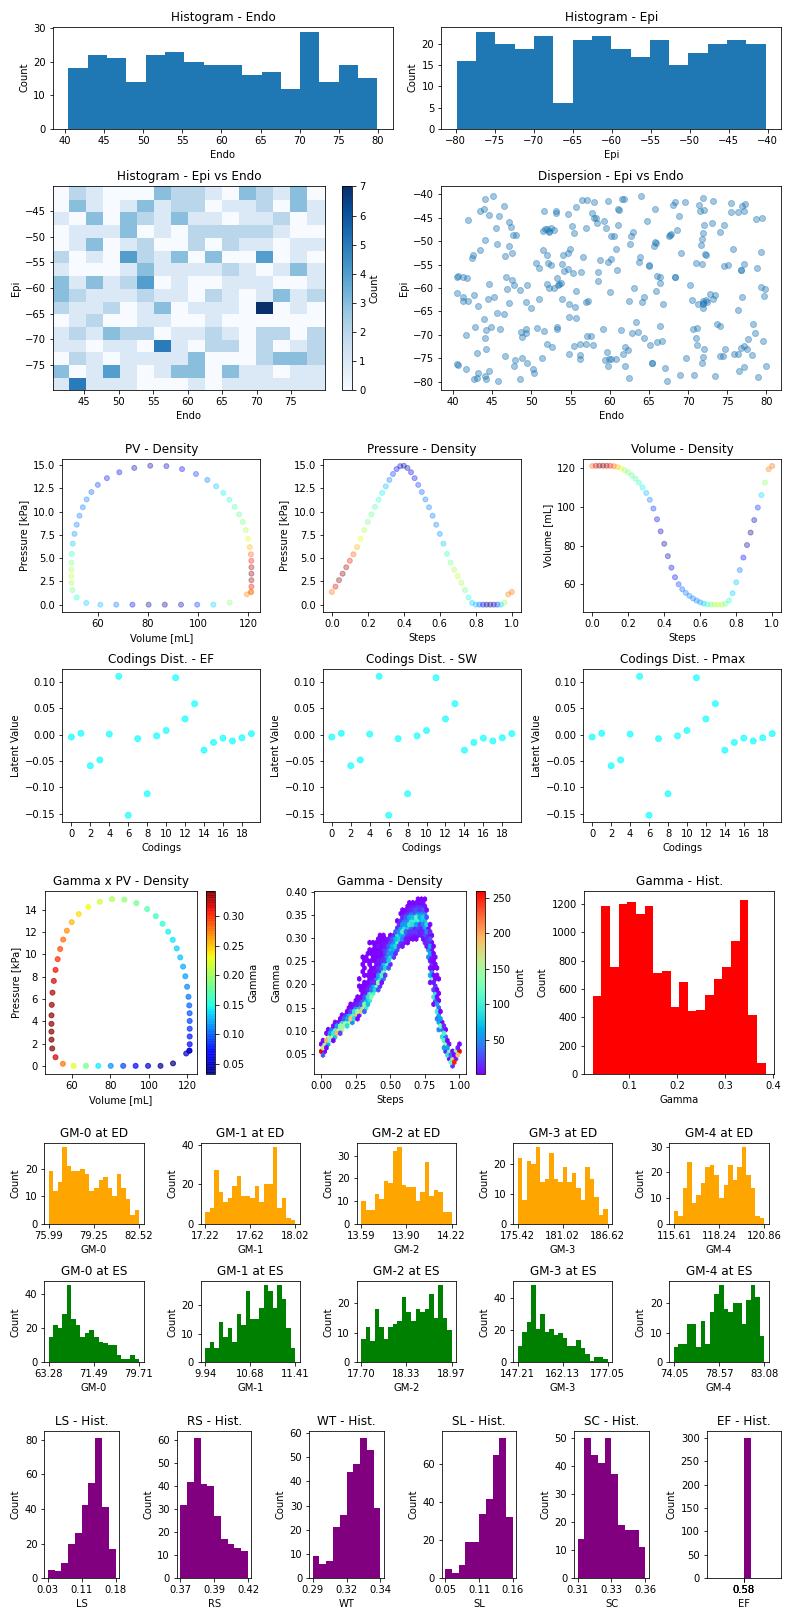

In [47]:
visualize_batch(data["info"])

In [48]:
data = gen_sample_batch(300, 1, "normal")

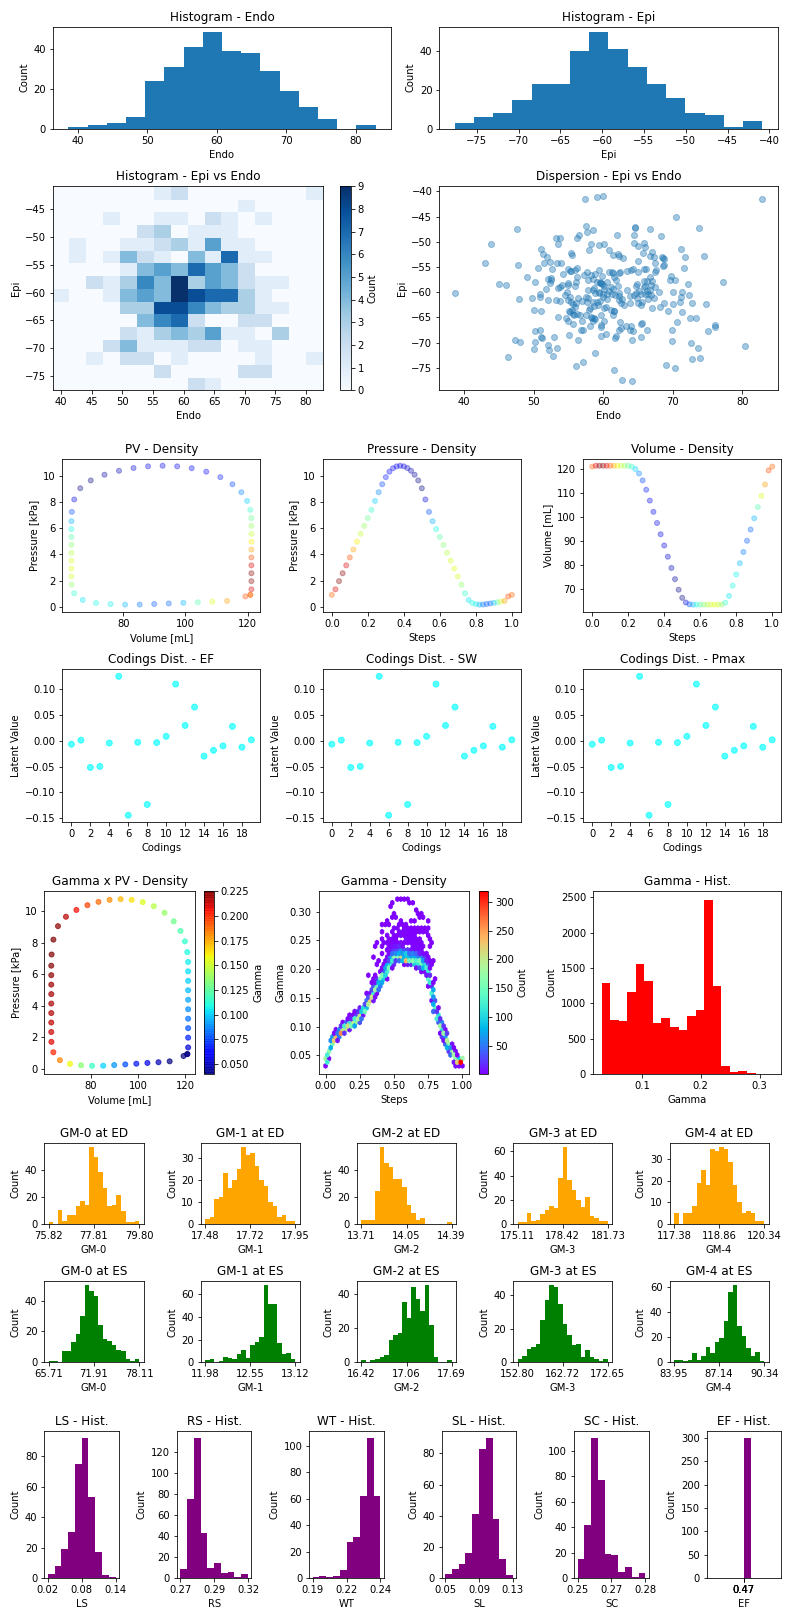

In [49]:
visualize_batch(data["info"])

In [50]:
data = gen_sample_batch(1, 1, "linear")

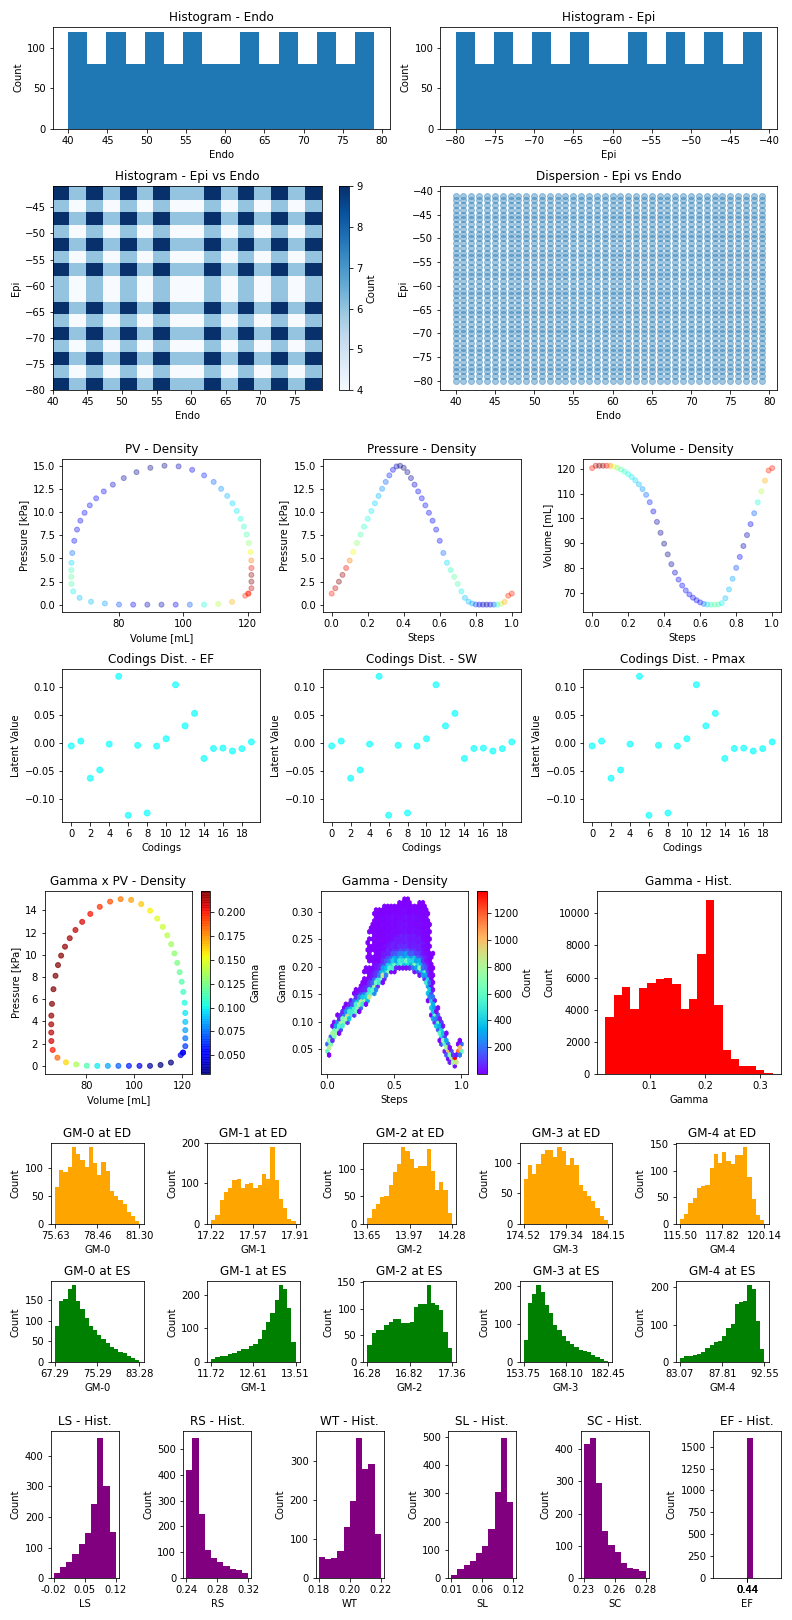

In [51]:
visualize_batch(data["info"])

In [52]:
data.keys()

dict_keys(['fo', 'pv', 'cm', 'gw', 'cv', 'info'])

In [53]:
data["gw"][0].shape

(51, 1)

In [54]:
pv = data["pv"][0]
pv.shape

(51, 2)

In [55]:
all_dfs = []
PVA = PV_Analyst()

ps = pv[:,0]
vs = pv[:, 1]

for id, (fo, cm, gw) in enumerate(zip(data["fo"], data["cm"], data["gw"])):
  df = pd.DataFrame()
  
  df["pressure"] = ps
  df["volume"] = vs
  df["timestep"], _ = PVA.distribute_timespace(pv)
  df["id"] = "linear_test_{}".format(id)

  df["gamma"] = gw

  df["endo"] = fo[0]
  df["epi"] = fo[1]

  for i, key in enumerate(CM_LABELS):
    df[key] = cm[i]
  all_dfs.append(df)

In [56]:
df = pd.concat(all_dfs)

In [57]:
df

,pressure,volume,timestep,id,gamma,endo,epi,LS,RS,WT,SL,SC,EF
0,0.074697,0.992147,1.694781e-19,linear_test_0,0.041835,40.0,-80.0,0.078863,0.257818,0.196196,0.097861,0.234583,0.437342
1,0.110718,1.000000,2.857143e-03,linear_test_0,0.053435,40.0,-80.0,0.078863,0.257818,0.196196,0.097861,0.234583,0.437342
2,0.155329,1.000000,5.714286e-03,linear_test_0,0.067576,40.0,-80.0,0.078863,0.257818,0.196196,0.097861,0.234583,0.437342
3,0.201103,1.000000,8.571429e-03,linear_test_0,0.078007,40.0,-80.0,0.078863,0.257818,0.196196,0.097861,0.234583,0.437342
4,0.247587,1.000000,1.142857e-02,linear_test_0,0.086155,40.0,-80.0,0.078863,0.257818,0.196196,0.097861,0.234583,0.437342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.000000,0.878679,6.355812e-01,linear_test_1599,0.037886,79.0,-41.0,0.117127,0.244594,0.213711,0.118513,0.231767,0.437342
47,0.005024,0.914918,6.755721e-01,linear_test_1599,0.031197,79.0,-41.0,0.117127,0.244594,0.213711,0.118513,0.231767,0.437342
48,0.018646,0.950528,7.163412e-01,linear_test_1599,0.032449,79.0,-41.0,0.117127,0.244594,0.213711,0.118513,0.231767,0.437342
49,0.060464,0.984189,7.579036e-01,linear_test_1599,0.047023,79.0,-41.0,0.117127,0.244594,0.213711,0.118513,0.231767,0.437342


## test mutliple batches (sample ds)

In [58]:
sample_ds = [gen_sample_batch(30, 10)["info"] for _ in range(50)]

In [59]:
sample_ds_info = [np.vstack(d) for d in zip(*sample_ds)]

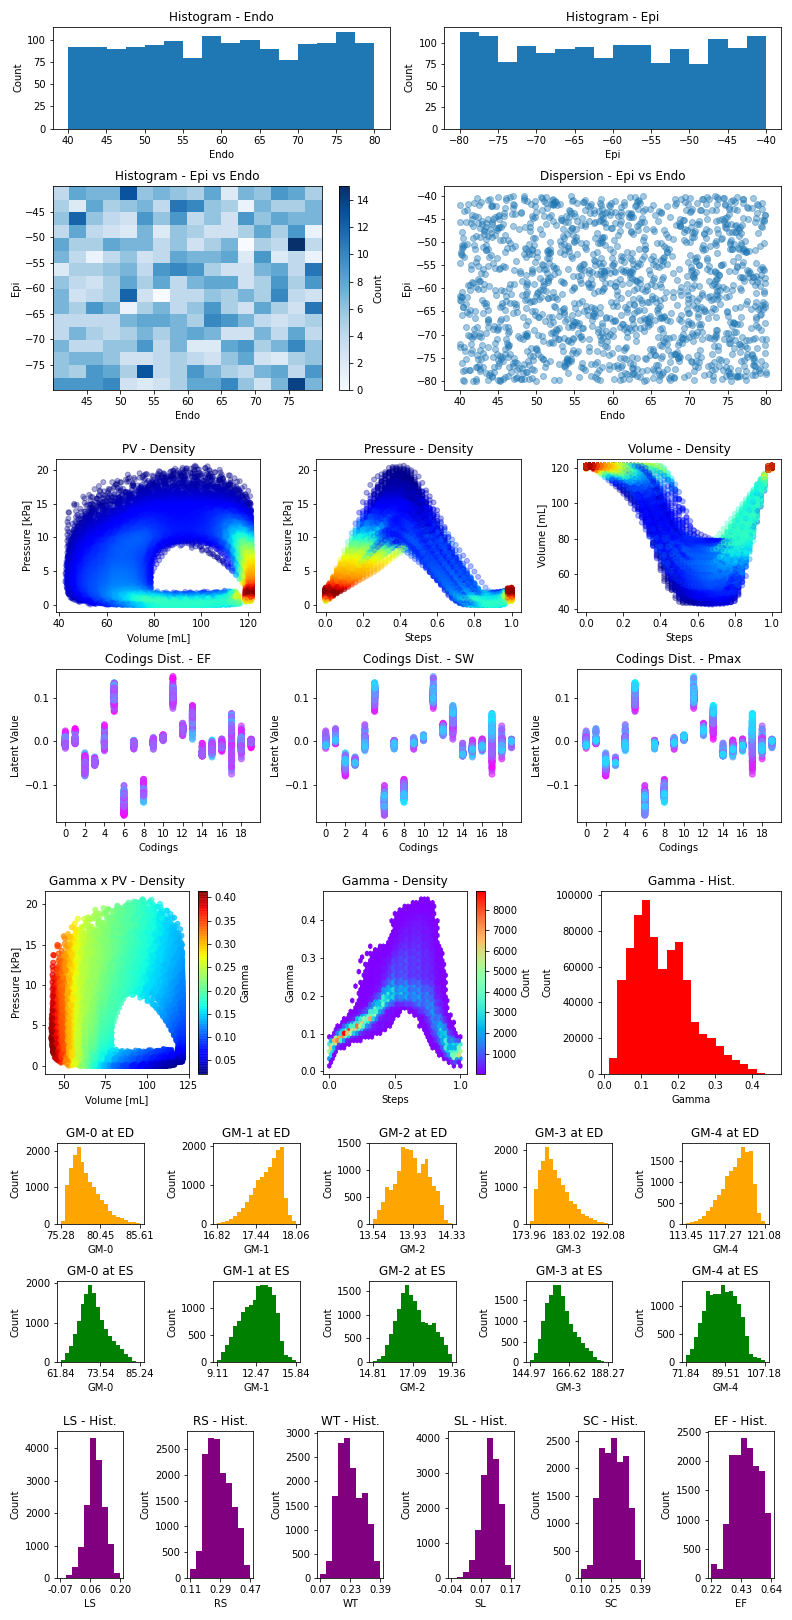

In [60]:
visualize_batch(sample_ds_info)

In [61]:
def gen_sample_list_ds(n_fo, n_pv, n_batches, fo_dist="uniform"):
  sample_ds = [gen_sample_batch(n_fo, n_pv, fo_dist) for _ in range(n_batches)]
  return sample_ds

In [62]:
def visualize_sample_list_ds(sample_ds):
  ds_infos = [data["info"] for data in sample_ds]
  sample_ds_info = [np.vstack(d) for d in zip(*ds_infos)]
  return visualize_batch(sample_ds_info)

# Create generator

## create generator utils

In [63]:
def compute_n_fibers_n_pvs(n_samples, batch_size, fo_pv_ratio, 
                           appx="floor"):
  
  n_batches = int(np.round(n_samples/batch_size))

  n_pv = np.sqrt(batch_size / fo_pv_ratio)
  n_fo = fo_pv_ratio * n_pv

  total_exact = n_batches*n_fo*n_pv
  if appx == "round":
    n_fo_int = np.round(n_fo, 0)
    n_pv_int = np.round(n_pv, 0)
  elif appx == "floor":
    n_fo_int = np.floor(n_fo)
    n_pv_int = np.floor(n_pv)
  elif appx == "ceil":
    n_fo_int = np.ceil(n_fo)
    n_pv_int = np.ceil(n_pv)
  else:
    raise ValueError("Not valid appx method.")

  n_fo_int = int(n_fo_int)
  n_pv_int = int(n_pv_int)
  
  total_est = n_batches*n_fo_int*n_pv_int
  if total_est != n_samples:
    print("Could not reach desired n_samples due to rounding:")
    print("Exact: {} * n_fo [{:.3f}] * n_pv [{:.3f}] = {:.3f}"
    .format(n_batches, n_fo, n_pv, total_exact))
    print("Rounded: {} * n_fo [{}] * n_pv [{}] = {}"
    .format(n_batches, n_fo_int, n_pv_int, total_est))
    
  return n_batches, n_fo_int, n_pv_int, total_est

## create generator

In [64]:
# @tf.function
from collections import deque
def set_ds_generator(
    n_samples, batch_size, fo_pv_ratio, fo_dist="uniform"
  ):

  n_batches, n_fo, n_pv, n = compute_n_fibers_n_pvs(n_samples, batch_size, fo_pv_ratio)
  
  def gen_series():
    for i in range(n_batches):
      data = gen_sample_batch(n_fo, n_pv, fo_dist)
      del data["info"]
      yield data

  return gen_series

In [65]:
# @tf.function
from collections import deque
def set_ds_generator_from_list_ds(list_ds):
  
  def gen_series():
    for data in list_ds:
      if "info" in data:
        del data["info"]
      yield data

  return gen_series

In [66]:
output_types = {
    "fo": tf.float32,
    "pv": tf.float32, 
    "cm": tf.float32, 
    "gw": tf.float32,
    "cv": tf.float32,
    # "info": tf.float32
}

## test generator

In [67]:
ds = tf.data.Dataset.from_generator(set_ds_generator(100, 5, 3), 
                                    output_types=output_types)

Could not reach desired n_samples due to rounding:
Exact: 20 * n_fo [3.873] * n_pv [1.291] = 100.000
Rounded: 20 * n_fo [3] * n_pv [1] = 60


In [68]:
for x in ds.take(1):
  print(x["pv"].shape)

(3, 51, 2)


# Generate Dataset

In [69]:
n_train = 10000
n_valid = 3500
n_test = 1000

batch_size = 200

total = n_train + n_valid + n_test
print("Desired Total: ", total)
print("Ratio: {:.2f}/{:.2f}/{:.2f}".format(
    n_train/total*100, n_valid/total*100, n_test/total*100))
print("---------")

bs_train, n_fo_train, n_pv_train, n_train = compute_n_fibers_n_pvs(n_train, batch_size, 3)
bs_valid, n_fo_valid, n_pv_valid, n_valid = compute_n_fibers_n_pvs(n_valid, batch_size, 3)
bs_test, n_fo_test, n_pv_test, n_test = compute_n_fibers_n_pvs(n_test, batch_size, 3)

train_batch_size = n_fo_train * n_pv_train
valid_batch_size = n_fo_valid * n_pv_valid
test_batch_size = n_fo_test * n_pv_train

print("---------")
print("Desired batch size = {}".format(batch_size))
print("train [fo, pv]: {}, {} -> {} samples per batch -> {} batches => {} total"
  .format(n_fo_train, n_pv_train, train_batch_size, bs_train, n_train))
print("valid [fo, pv]: {}, {} -> {} samples per batch -> {} batches => {} total"
  .format(n_fo_valid, n_pv_valid, valid_batch_size, bs_valid, n_valid))
print("test [fo, pv]: {}, {} -> {} samples per batch -> {} batches => {} total"
  .format(n_fo_test, n_pv_test, test_batch_size, bs_test, n_test))

print("---------")
total = n_train + n_valid + n_test
print("Total: ", total)
print("Ratio: {:.2f}/{:.2f}/{:.2f}".format(
    n_train/total*100, n_valid/total*100, n_test/total*100))

Desired Total:  14500
Ratio: 68.97/24.14/6.90
---------
Could not reach desired n_samples due to rounding:
Exact: 50 * n_fo [24.495] * n_pv [8.165] = 10000.000
Rounded: 50 * n_fo [24] * n_pv [8] = 9600
Could not reach desired n_samples due to rounding:
Exact: 18 * n_fo [24.495] * n_pv [8.165] = 3600.000
Rounded: 18 * n_fo [24] * n_pv [8] = 3456
Could not reach desired n_samples due to rounding:
Exact: 5 * n_fo [24.495] * n_pv [8.165] = 1000.000
Rounded: 5 * n_fo [24] * n_pv [8] = 960
---------
Desired batch size = 200
train [fo, pv]: 24, 8 -> 192 samples per batch -> 50 batches => 9600 total
valid [fo, pv]: 24, 8 -> 192 samples per batch -> 18 batches => 3456 total
test [fo, pv]: 24, 8 -> 192 samples per batch -> 5 batches => 960 total
---------
Total:  14016
Ratio: 68.49/24.66/6.85


In [70]:
ds_train = tf.data.Dataset.from_generator(set_ds_generator(n_train, batch_size, 3), 
                                    output_types=output_types)
ds_valid = tf.data.Dataset.from_generator(set_ds_generator(n_valid, batch_size, 3), 
                                    output_types=output_types)
ds_test = tf.data.Dataset.from_generator(set_ds_generator(n_test, batch_size, 3), 
                                    output_types=output_types)

Could not reach desired n_samples due to rounding:
Exact: 48 * n_fo [24.495] * n_pv [8.165] = 9600.000
Rounded: 48 * n_fo [24] * n_pv [8] = 9216
Could not reach desired n_samples due to rounding:
Exact: 17 * n_fo [24.495] * n_pv [8.165] = 3400.000
Rounded: 17 * n_fo [24] * n_pv [8] = 3264


In [71]:
n_sample = 200

bs_sample, n_fo_sample, n_pv_sample, n_sample = compute_n_fibers_n_pvs(n_sample, 8, 2)
sample_batch_size = n_fo_sample * n_pv_sample

print("sample [fo, pv]: {}, {} -> {} samples per batch -> {} batches => {} total"
  .format(n_fo_sample, n_pv_sample, sample_batch_size, bs_sample, n_sample))

sample [fo, pv]: 4, 2 -> 8 samples per batch -> 25 batches => 200 total


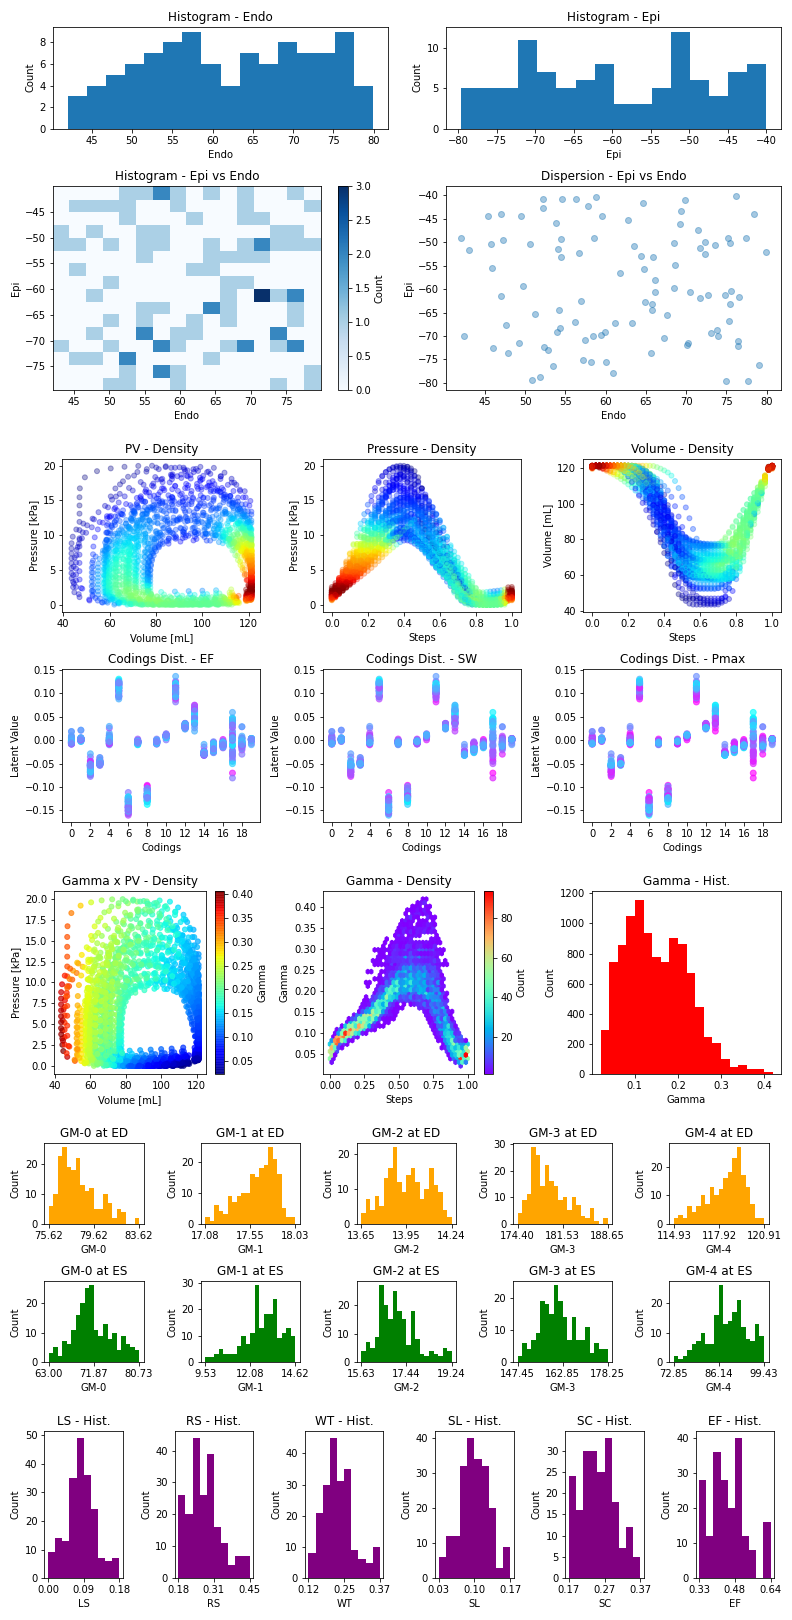

In [72]:
sample_list_ds = gen_sample_list_ds(n_fo_sample, n_pv_sample, bs_sample, "uniform")
visualize_sample_list_ds(sample_list_ds)

In [73]:
ds_sample = tf.data.Dataset.from_generator(set_ds_generator_from_list_ds(sample_list_ds), 
                                    output_types=output_types)

In [74]:
for x in ds_sample.take(1):
  print(x["pv"].shape)

(8, 51, 2)


## visualize samples

### utils

In [75]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height < 0:
          va = "top"
          yof = -7
        else:
          va = "bottom"
          yof = 7
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, yof),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va=va)

In [76]:
def plot_training_data(pv, pv_norm, gw, cm, fo, ts,
                         cm_labels=CM_LABELS, title="Training",
                         figsize=(10,8)):

  fig, axs = plt.subplots(3, 3, figsize=figsize, 
                            gridspec_kw={'width_ratios': [1, 1.8, 1.2]})

  # -- FIRST ROW
  # --- first and axis ---
  PVA.plot_pv(pv=pv_norm, color_mask="phases", legend=False,
                expanded_plot=True, pvl=True, ax=axs[0][:2], equal=True)
  axs[0][0].set_title("Normalized PV loop")
  axs[0][1].set_title("Normalized PV waveforms")
  # --- plot bin distribution ---
  pcm = axs[0][2].scatter(np.linspace(0, 1, len(ts)), ts, c=gw, cmap="jet")
  bar = fig.colorbar(pcm, ax=axs[0][2])
  axs[0][2].set_title("Time vs steps")
  axs[0][2].set_xlabel("Timesteps [s]")
  axs[0][2].set_ylabel("Steps")
  bar.set_label("Gamma")
  # -- SECOND ROW
  # --- first and second axis ---
  PVA.plot_pv(pv=pv, color_mask="phases", legend=False, equal=False, xs=ts,
                  expanded_plot=True, pvl=True, ax=axs[1][:2])
  axs[1][0].set_title("Scaled PV loop")
  axs[1][1].set_title("Scaled PV waveforms")
  # --- plot cms ---ax.bar(langs,students)
  rects = axs[1][2].bar(cm_labels, cm)
  autolabel(rects, axs[1][2])
  axs[1][2].set_ylim((min(cm) *0.9, max(cm) *1.2))
  axs[1][2].set_title("CM input profile")
  axs[1][2].set_ylabel("Value [%]")
  # -- THIRD ROW
  # --- first axis
  pcm = axs[2][0].scatter(pv[:, 1], pv[:, 0], c=gw, cmap="jet")
  bar = fig.colorbar(pcm, ax=axs[2][0])
  axs[2][0].set_title("PV Loop")
  bar.set_label("Gamma")
  # --- second axis
  phases, _ = PVA.get_pv_phases()
  axs[2][1].scatter(ts, gw, c=phases, cmap="rainbow")
  axs[2][1].set_title("Gamma Waveform")
  axs[2][1].set_ylabel("Gamma")
  # --- third axis
  # axs[3][2].bar(fo_true, fo_label)
  xfo = np.arange(2)
  fo_width = 0.5
  fo[1] = -fo[1]
  rects1 = axs[2][2].bar(xfo - fo_width/2, fo, fo_width, label='fo')
  axs[2][2].set_title("Fiber profile (ABS)")
  axs[2][2].set_xticks(xfo)
  axs[2][2].set_xticklabels(["endo", "epi"])
  # axs[2][2].legend(loc='center')
  axs[2][2].set_ylim((35, 85))
  autolabel(rects1, axs[2][2])
  axs[2][2].set_ylabel("Value [degree]")

  fig.suptitle(title)
  # fig.tight_layout(pad=1.01)
  # fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=1.01)
  fig.tight_layout(rect=[0, 0, 1.01, 0.96])
  # fig.tight_layout()
  return fig, axs

### visualization

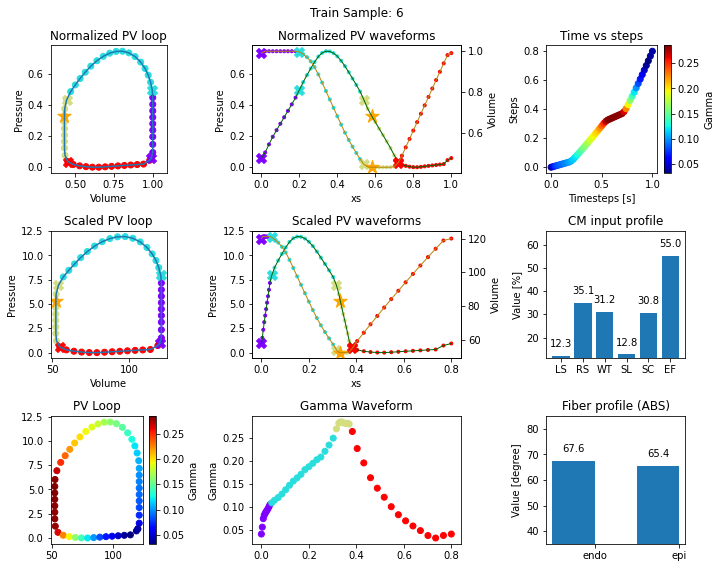

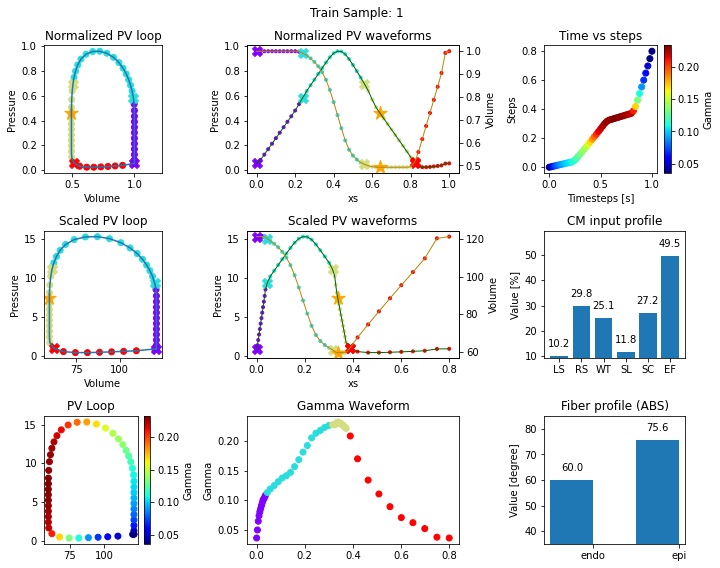

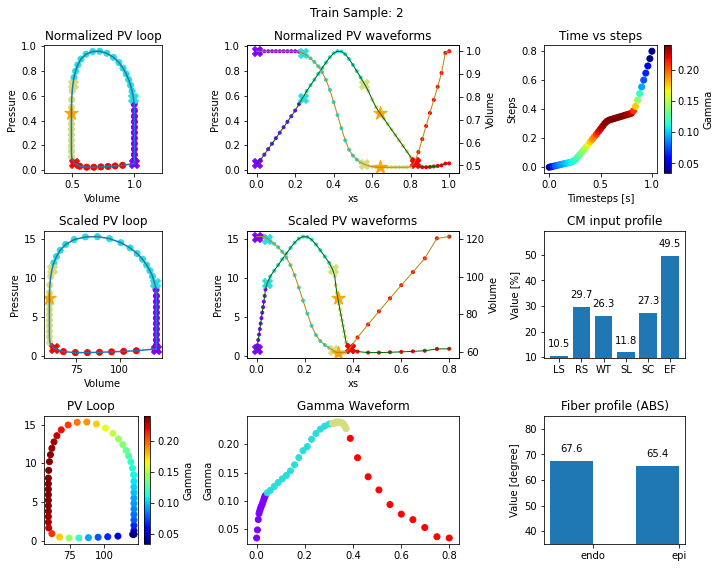

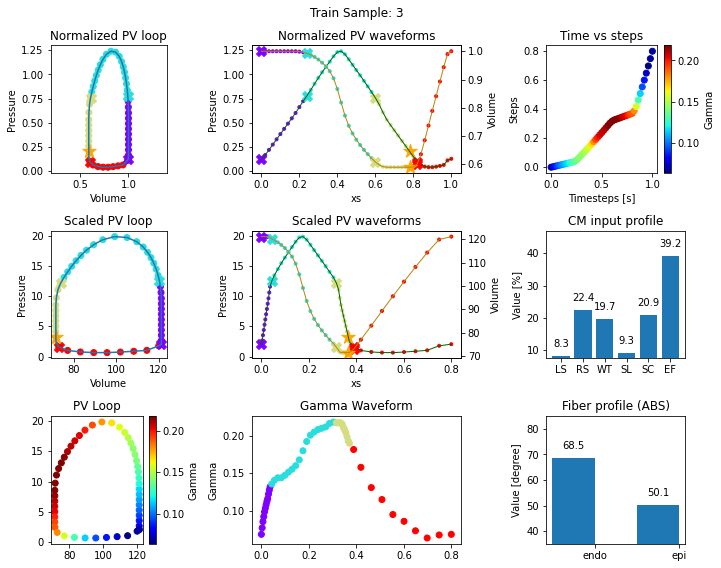

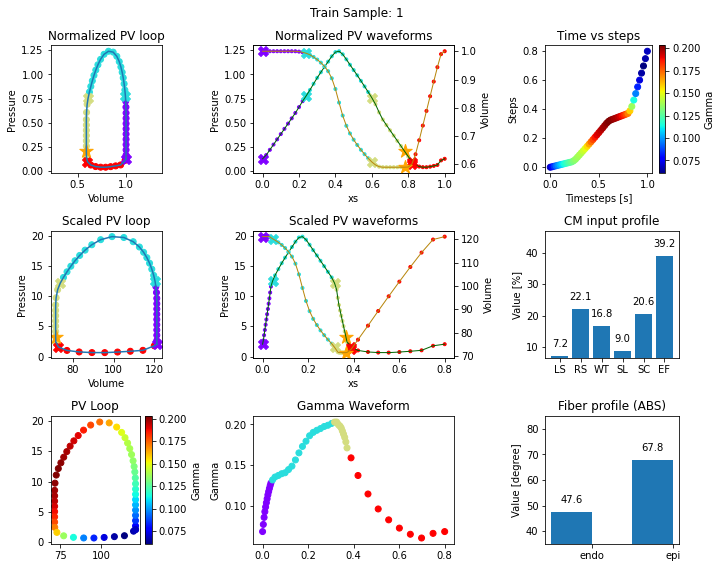

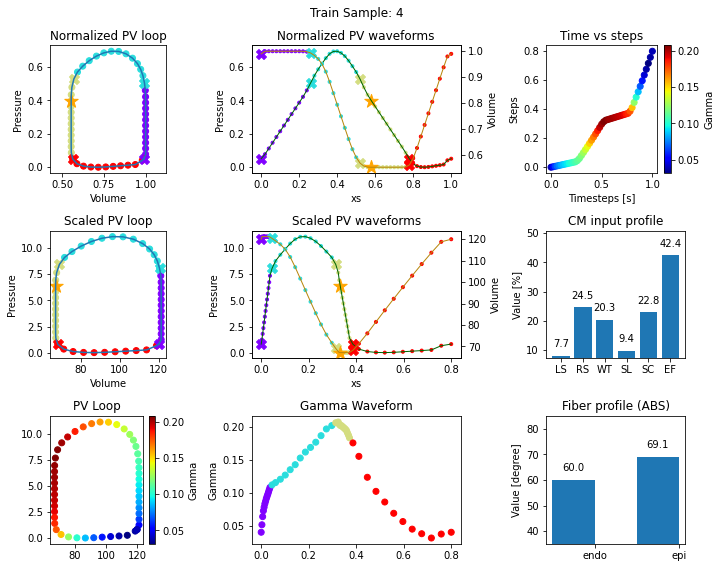

In [77]:
N_BATCHES = 2
N_SAMPLES = 3

for bidx, data in enumerate(ds_sample.take(N_BATCHES)):
  used_options = set()
  for si in range(N_SAMPLES):

    # randomly choose option from batch
    options = np.arange(0, data["fo"].shape[0], 1, dtype=np.int32)
    i = np.random.choice(options)
    while i in used_options:
      i = np.random.choice(options)
    used_options.add(i)

    # get data
    cm = data["cm"][i]*100.0
    pv = data["pv"][i]
    fo = data["fo"][i]
    gw = data["gw"][i]

    # plot data
    PVA = PV_Analyst(pv)
    ts, _ = PVA.distribute_timespace(max_time=0.8)
    pv_norm = pv.numpy()
    pv = scale_pv_for_display(pv)
    plot_training_data(pv, pv_norm, gw, cm, fo.numpy(), ts,
                          title="Train Sample: {}".format(i)
                        )

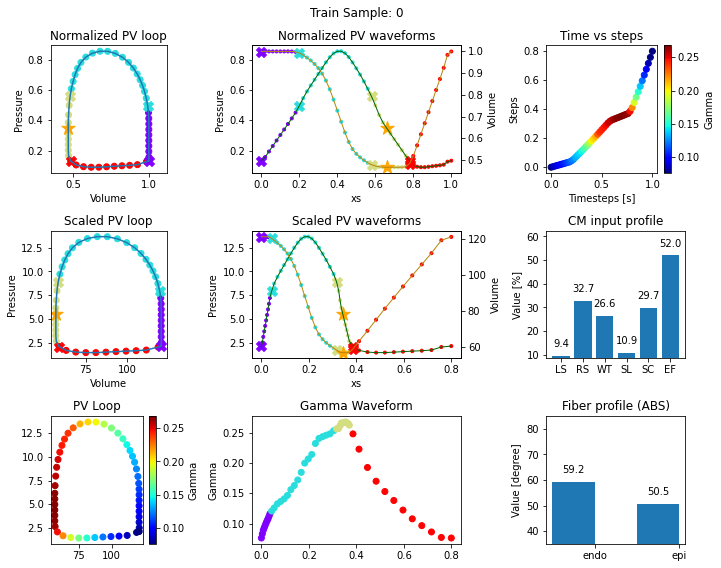

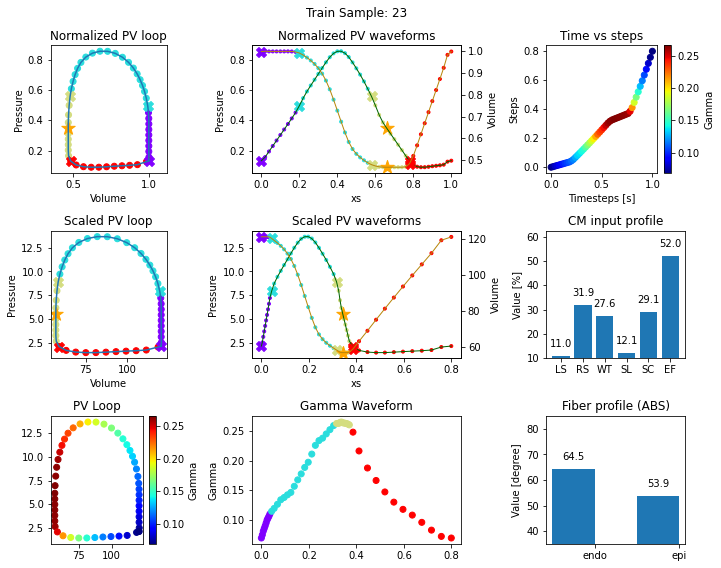

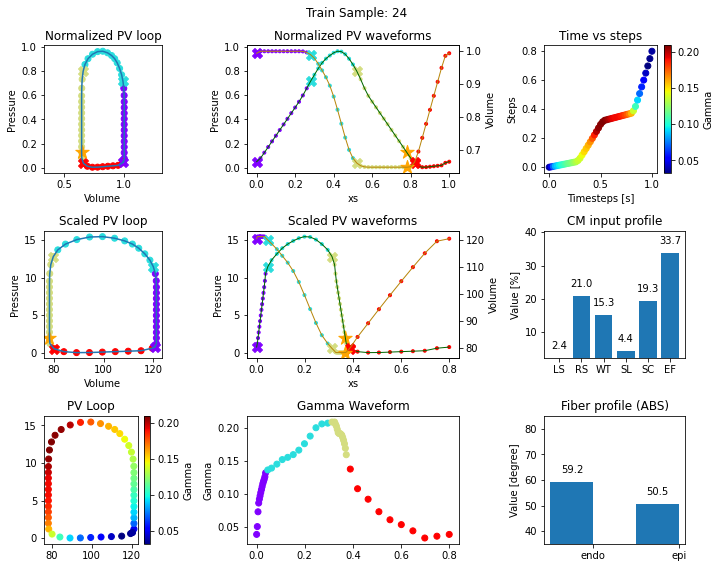

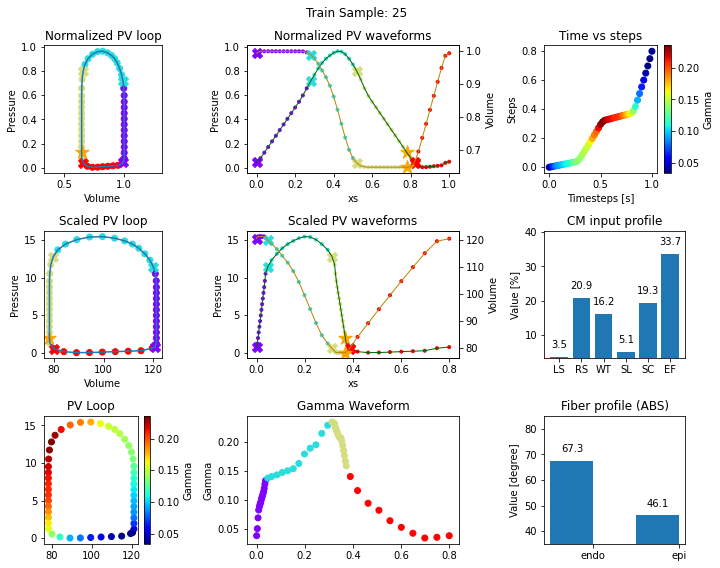

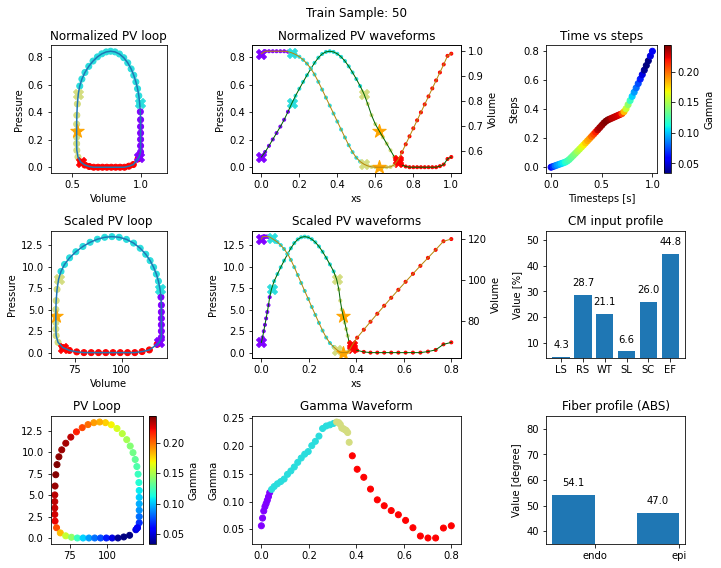

In [78]:
N_BATCHES = 1
N_SAMPLES = 2

for bidx, data in enumerate(ds_train.take(N_BATCHES)):
  # print(data)
  # for i in range(N_SAMPLES):
  for i in [0, 23, 24, 25, 50]:
    cm = data["cm"][i]*100.0
    pv = data["pv"][i]
    fo = data["fo"][i]
    gw = data["gw"][i]

    PVA = PV_Analyst(pv)
    ts, _ = PVA.distribute_timespace(max_time=0.8)
    pv_norm = pv.numpy()
    pv = scale_pv_for_display(pv)
    plot_training_data(pv, pv_norm, gw, cm, fo.numpy(), ts,
                          title="Train Sample: {}".format(i)
                        )

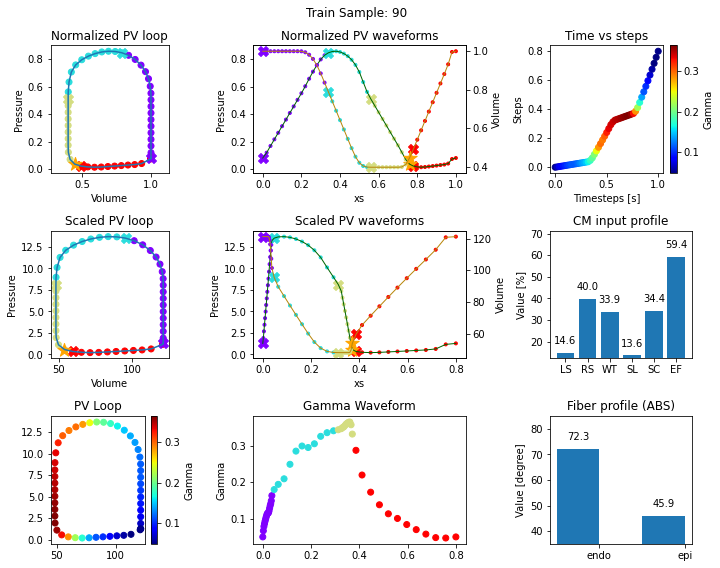

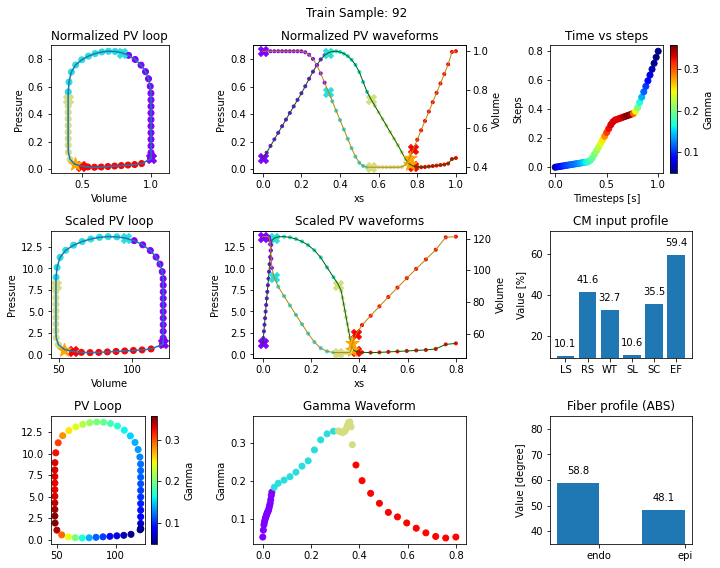

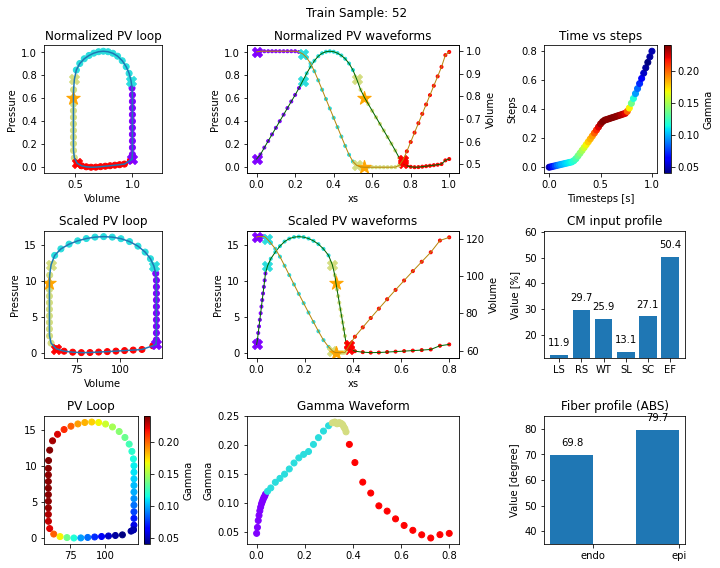

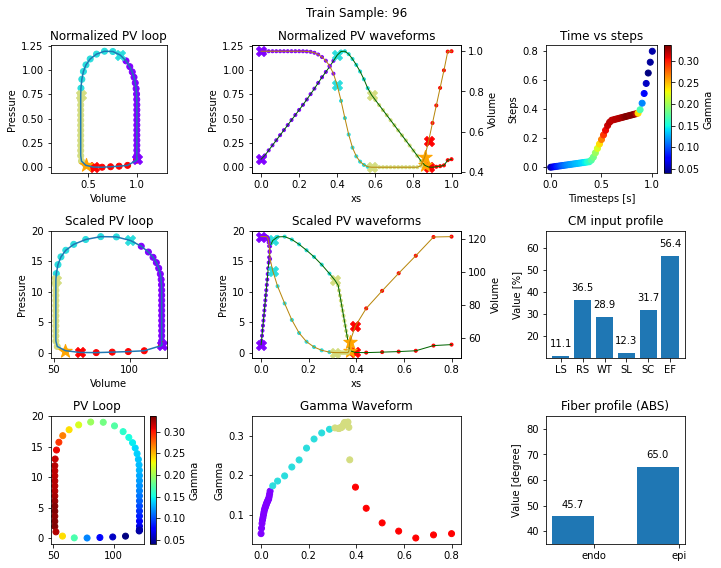

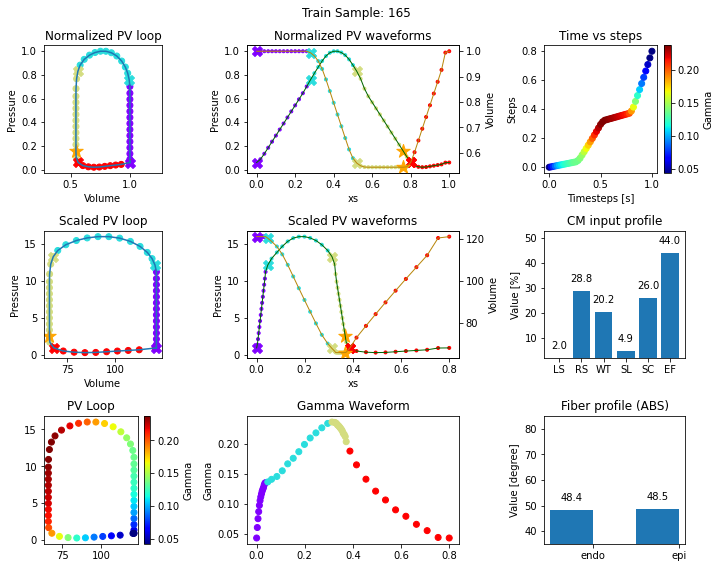

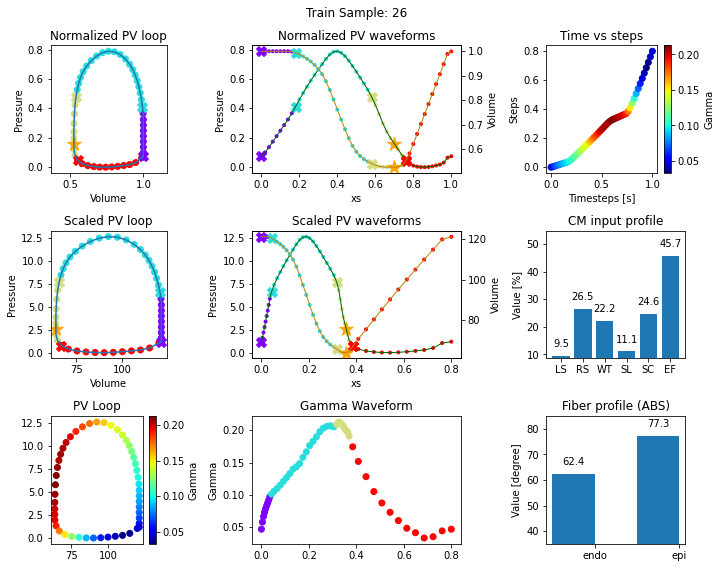

In [79]:
N_BATCHES = 2
N_SAMPLES = 3

for bidx, data in enumerate(ds_train.take(N_BATCHES)):
  used_options = set()
  for si in range(N_SAMPLES):

    # randomly choose option from batch
    options = np.arange(0, data["fo"].shape[0], 1, dtype=np.int32)
    i = np.random.choice(options)
    while i in used_options:
      i = np.random.choice(options)
    used_options.add(i)

    # get data
    cm = data["cm"][i]*100.0
    pv = data["pv"][i]
    fo = data["fo"][i]
    gw = data["gw"][i]

    # plot data
    PVA = PV_Analyst(pv)
    ts, _ = PVA.distribute_timespace(max_time=0.8)
    pv_norm = pv.numpy()
    pv = scale_pv_for_display(pv)
    plot_training_data(pv, pv_norm, gw, cm, fo.numpy(), ts,
                          title="Train Sample: {}".format(i)
                        )

# gen ds

In [80]:
tf.data.experimental.save(ds_train, str(ROOT_DIR/"DL_MODEL_DS"/"ds_pat_train"))
tf.data.experimental.save(ds_valid, str(ROOT_DIR/"DL_MODEL_DS"/"ds_pat_valid"))
tf.data.experimental.save(ds_test, str(ROOT_DIR/"DL_MODEL_DS"/"ds_pat_test"))

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [81]:
# tf.data.experimental.save(ds_sample, str(ROOT_DIR/"ds_ideal_sample"))